# Fase 1 (MLOps): EDA, Anti-Leakage, Particionado, Baselines y Artefactos
1. Objetivo

Implementar un flujo reproducible de pre-modelado que:

1. cargue y describa el dataset obesity_estimation_original.csv,

2. ejecute un EDA (numérico y visual) y controles anti-leakage,

3. realice un particionado estratificado 60/20/20 (train/val/test),

4. construya un pipeline sin fuga (imputación, codificación y escala),

5. entrene modelos baseline (Logistic Regression, Random Forest), y

6. guarde métricas y artefactos para trazabilidad y auditoría.

In [14]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')

# === RUTAS ===
DATA_DIR = Path("/content/drive/MyDrive/MLOps")          # carpeta donde está tu CSV
OUT_DIR  = Path("/content/drive/MyDrive/mlops_fase1_artifacts")  # artefactos

OUT_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "data").mkdir(exist_ok=True)
(OUT_DIR / "models").mkdir(exist_ok=True)
(OUT_DIR / "reports").mkdir(exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("OUT_DIR:", OUT_DIR)

import os, glob
print("Archivos CSV en DATA_DIR:", glob.glob(str(DATA_DIR / "*.csv")))

csv_path = DATA_DIR / "obesity_estimation_original.csv"
if not csv_path.exists():
    raise FileNotFoundError(
        f"No se encontró {csv_path}. "
        "Confirma el nombre exacto del archivo y que esté en /content/drive/MyDrive/MLOps"
    )
print("OK, encontrado:", csv_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR: /content/drive/MyDrive/MLOps
OUT_DIR: /content/drive/MyDrive/mlops_fase1_artifacts
Archivos CSV en DATA_DIR: ['/content/drive/MyDrive/MLOps/obesity_estimation_original.csv']
OK, encontrado: /content/drive/MyDrive/MLOps/obesity_estimation_original.csv


# IMPORTACION DE LIBRERIAS


In [15]:
import os                           # utilidades del sistema de archivos
import sys                          # información del intérprete (versiones, etc.)
import json                         # lectura/escritura de archivos JSON
import glob                         # listado de archivos con patrones (e.g., *.csv)
import warnings                     # control de warnings para salida limpia
from datetime import datetime       # sellos de tiempo
from pathlib import Path            # manejo de rutas multiplataforma

# NumPy / Pandas
import numpy as np                  # operaciones numéricas vectorizadas
import pandas as pd                 # manipulación tabular

# Visualización
import matplotlib.pyplot as plt     # gráficos (histogramas, boxplots, heatmaps)

# Scikit-learn: preprocesamiento, modelado, evaluación
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Serialización de modelos
import joblib                       # guardar/cargar pipelines entrenados


# Configuración global opcional
warnings.filterwarnings("ignore")   # oculta warnings no críticos
plt.rcParams.update({"figure.dpi": 120})  # mejora nitidez por defecto en figuras


In [16]:
def save_json(data: dict, path: Path):
    """Guarda un dict como JSON legible (indent=2, UTF-8)."""
    path.write_text(json.dumps(data, indent=2, ensure_ascii=False))  # serializa y persiste

def eda_report(df: pd.DataFrame, target: str) -> dict:
    """Crea un EDA básico con forma, tipos, nulos, distribución del target y describe numérico."""
    return {
        "shape": list(df.shape),                                   # [n_filas, n_cols]
        "columns": df.columns.tolist(),                            # nombres de columnas
        "dtypes": {c: str(t) for c, t in df.dtypes.items()},       # tipos por columna
        "missing_by_col": df.isna().sum().sort_values(ascending=False).to_dict(),  # nulos por columna
        "target_counts": df[target].value_counts(dropna=False).to_dict(),          # distribución del target
        "sample_rows": df.head(5).to_dict(orient="records"),       # primeras filas como muestra
        "describe_numeric": df.select_dtypes(include="number").describe().to_dict()# resumen de numéricas
    }

def check_basic_leakage(df: pd.DataFrame, target: str) -> dict:
    """
    Heurísticas simples de fuga ANTES del split:
      - filas duplicadas
      - columnas idénticas al target
      - correlaciones extremas con target (solo si target fuera numérico)
    """
    leakage = {
        "duplicate_rows": int(df.duplicated().sum()),                               # conteo de duplicados
        "columns_equal_target": [c for c in df.columns if c != target and df[c].equals(df[target])],
        "high_corr_with_target": []                                                 # placeholder correlaciones extremas
    }
    # En este dataset el target suele ser categórico; si fuera numérico, revisamos correlaciones sospechosas
    if pd.api.types.is_numeric_dtype(df[target]):
        corr = df.corr(numeric_only=True)[target].drop(target, errors="ignore")
        leakage["high_corr_with_target"] = [c for c, v in corr.items() if abs(v) > 0.98]
    return leakage

def quick_infer_types(df: pd.DataFrame, target: str):
    """Separa columnas numéricas y categóricas excluyendo el target (para ColumnTransformer)."""
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()                 # detecta numéricas
    cat_cols = [c for c in df.columns if c not in num_cols and c != target]          # categóricas = resto sin target
    num_cols = [c for c in num_cols if c != target]                                  # por seguridad, excluye target
    return num_cols, cat_cols

def confusion_to_dict(y_true, y_pred, labels):
    """Convierte la matriz de confusión a un dict serializable (JSON)."""
    cm = confusion_matrix(y_true, y_pred, labels=labels)                             # calcula matriz
    return {"labels": list(map(str, labels)), "matrix": cm.tolist()}                 # empaqueta para JSON


In [17]:
# Leemos el CSV en un DataFrame
df = pd.read_csv(csv_path)

# Normalizamos los nombres de columnas (evita problemas con espacios)
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Definimos/detectamos el nombre del target
TARGET_NAME = "NObeyesdad"
if TARGET_NAME not in df.columns:
    # Si el nombre no coincide, tratamos alias comunes del dataset
    candidates = [c for c in df.columns if c.lower() in ["nobeyesdad", "obesity_level", "obesitylevel"]]
    if not candidates:
        raise ValueError(f"No se encontró la columna objetivo '{TARGET_NAME}'. Columnas: {df.columns.tolist()}")
    TARGET_NAME = candidates[0]
print("Target detectado:", TARGET_NAME)

# EDA mínimo y guardado a disco (trazabilidad)
eda = eda_report(df, TARGET_NAME)
save_json(eda, OUT_DIR / "reports" / "eda.json")

# Chequeos anti-leakage previos al split (no transforman datos)
leak_pre = check_basic_leakage(df, TARGET_NAME)
save_json(leak_pre, OUT_DIR / "reports" / "anti_leakage_pre_split.json")

print("EDA      ->", OUT_DIR / "reports" / "eda.json")
print("Leak(pre)->", OUT_DIR / "reports" / "anti_leakage_pre_split.json")
print("Resumen: shape", eda["shape"], "| target(top):", list(eda["target_counts"].items())[:5])


Target detectado: NObeyesdad
EDA      -> /content/drive/MyDrive/mlops_fase1_artifacts/reports/eda.json
Leak(pre)-> /content/drive/MyDrive/mlops_fase1_artifacts/reports/anti_leakage_pre_split.json
Resumen: shape [2111, 17] | target(top): [('Obesity_Type_I', 351), ('Obesity_Type_III', 324), ('Obesity_Type_II', 297), ('Overweight_Level_I', 290), ('Overweight_Level_II', 290)]


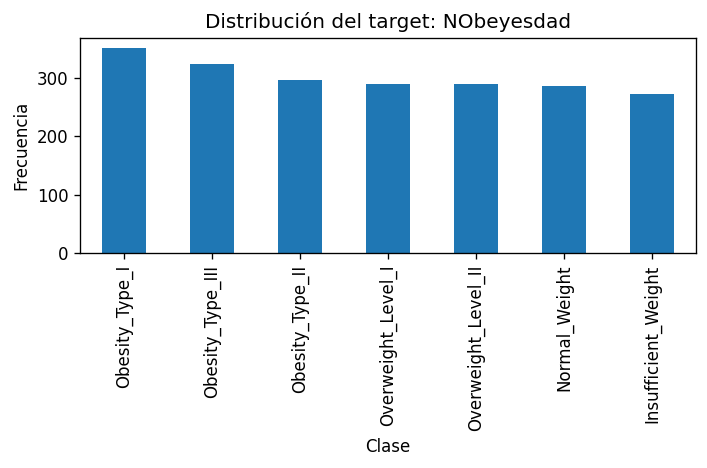

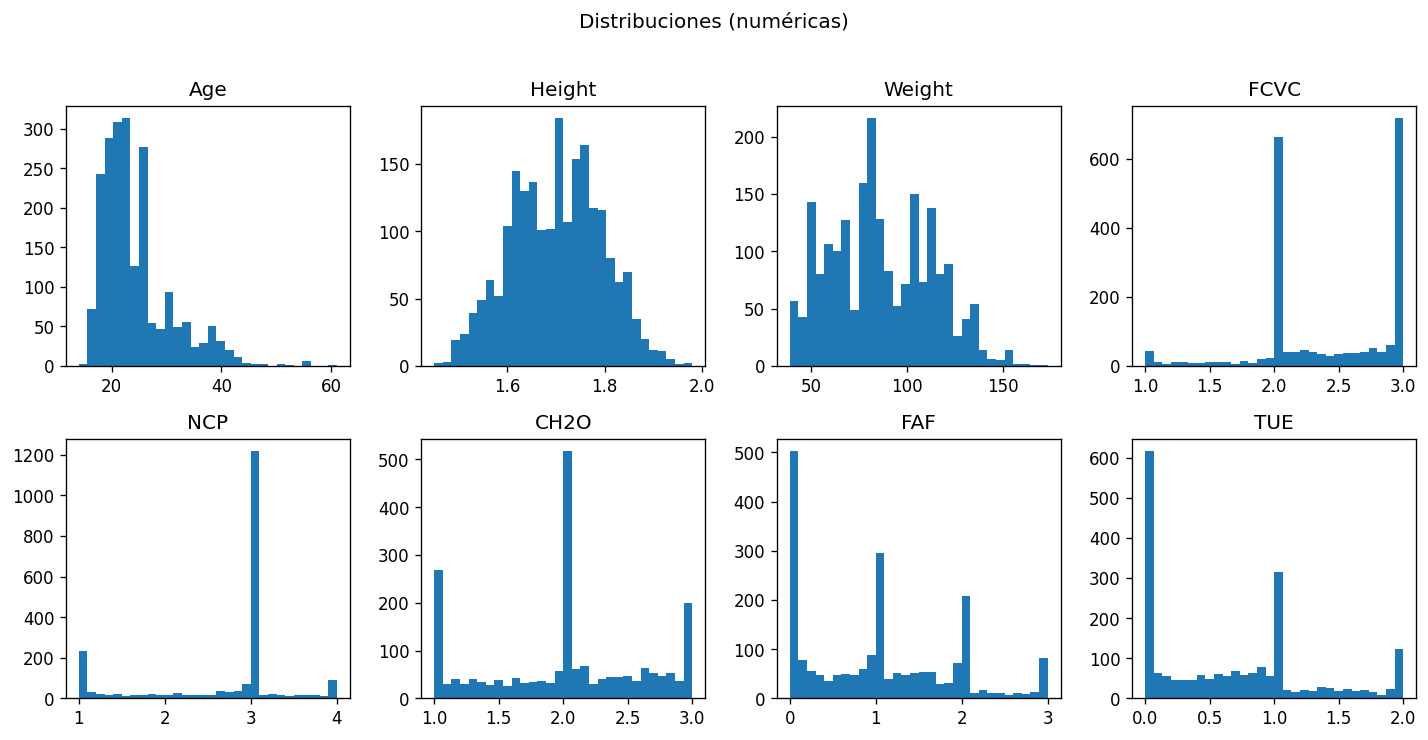

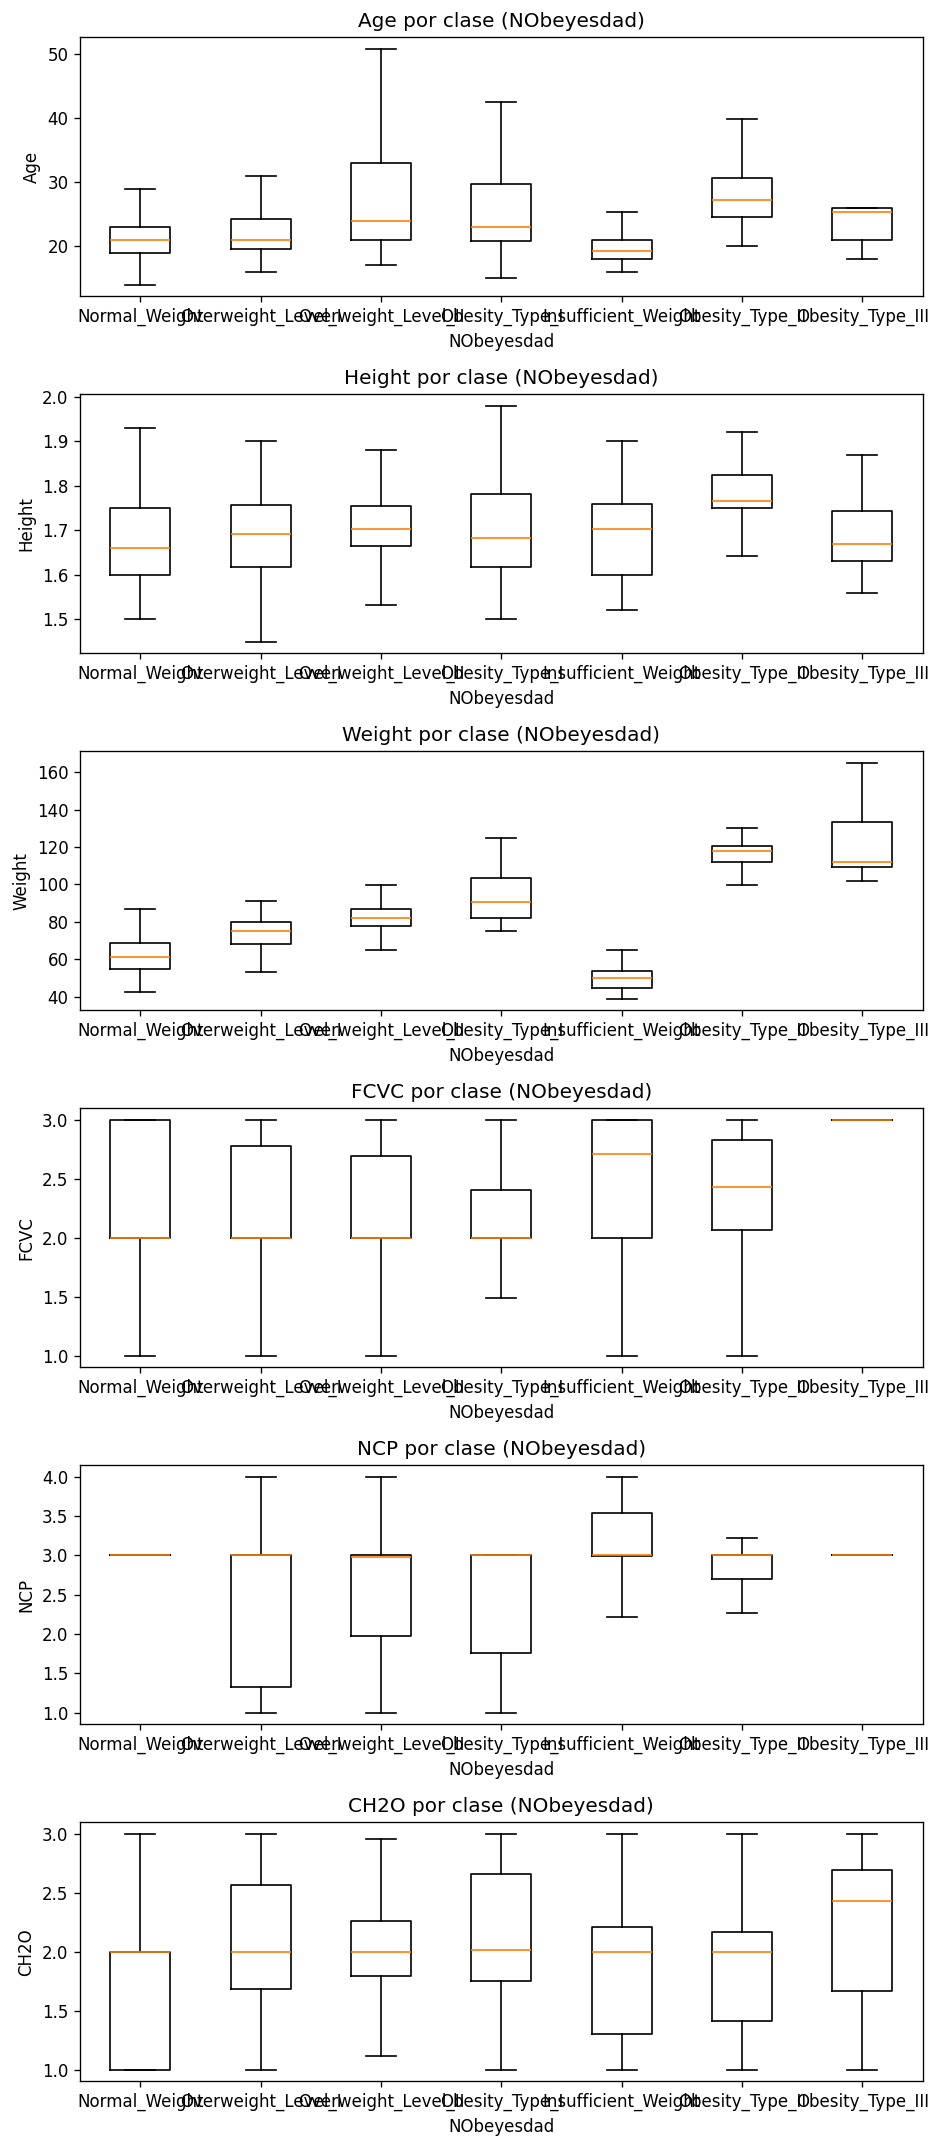

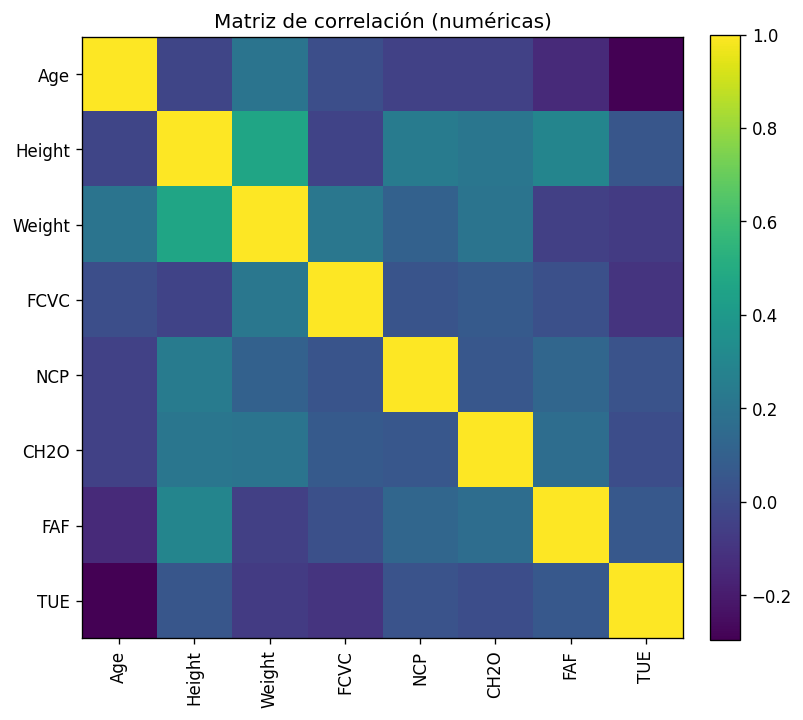

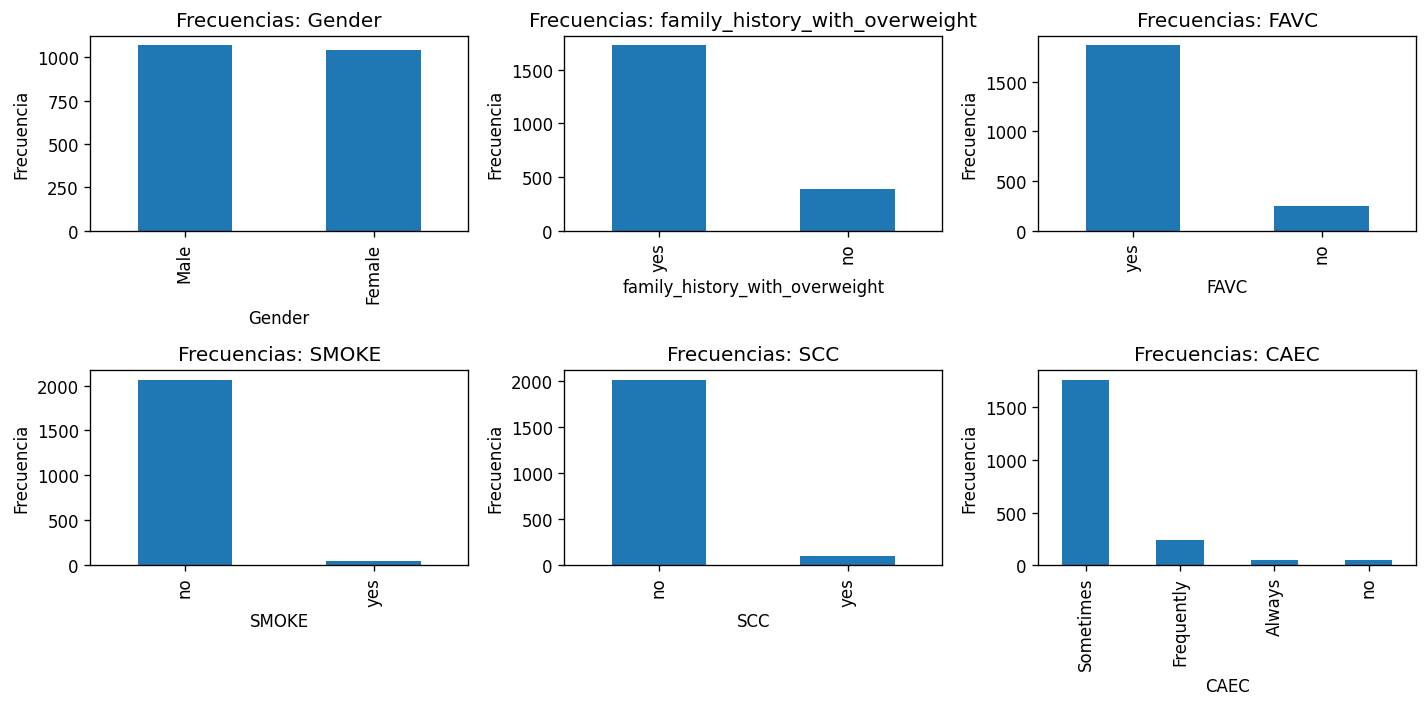

✓ Visual EDA generado. Imágenes en: /content/drive/MyDrive/mlops_fase1_artifacts/reports


In [18]:
# ==========================================================
# Visual EDA — Gráficas descriptivas
# ==========================================================

# Carpeta para figuras (usamos la misma de reportes)
fig_dir = OUT_DIR / "reports"
fig_dir.mkdir(exist_ok=True)

# 1) Distribución del target
fig, ax = plt.subplots(figsize=(6, 4))
df[TARGET_NAME].value_counts().plot(kind="bar", ax=ax)
ax.set_title(f"Distribución del target: {TARGET_NAME}")
ax.set_xlabel("Clase"); ax.set_ylabel("Frecuencia")
plt.tight_layout(); plt.show()
fig.savefig(fig_dir / "01_target_distribution.png")

# 2) Nulos por columna (si existen)
nulls = df.isna().sum().sort_values(ascending=False)
if nulls.sum() > 0:
    fig, ax = plt.subplots(figsize=(7, 4))
    nulls[nulls > 0].plot(kind="barh", ax=ax)
    ax.set_title("Valores nulos por columna")
    ax.set_xlabel("Cuenta de nulos")
    plt.tight_layout(); plt.show()
    fig.savefig(fig_dir / "02_missing_by_column.png")

# 3) Histogramas de numéricas (paginados para no saturar)
num_cols = df.select_dtypes(include="number").columns.tolist()
if len(num_cols) > 0:
    chunk = 8  # 8 subplots por figura
    for i in range(0, len(num_cols), chunk):
        cols = num_cols[i:i+chunk]
        n = len(cols); rows = int(np.ceil(n/4))
        fig, axes = plt.subplots(rows, min(n,4), figsize=(12, 3*rows), squeeze=False)
        axes = axes.ravel()
        for ax_j, col in zip(axes, cols):
            ax_j.hist(df[col].dropna(), bins=30)
            ax_j.set_title(col)
        for k in range(n, rows*4): axes[k].axis("off")
        plt.suptitle("Distribuciones (numéricas)", y=1.02, fontsize=12)
        plt.tight_layout(); plt.show()
        fig.savefig(fig_dir / f"03_numeric_hist_{i//chunk+1:02d}.png")

# 4) Boxplots de numéricas por clase del target (si target no es numérico)
is_target_cat = not pd.api.types.is_numeric_dtype(df[TARGET_NAME])
if is_target_cat and len(num_cols) > 0:
    top_num = num_cols[:6]  # límite a 6 para legibilidad
    fig, axes = plt.subplots(len(top_num), 1, figsize=(8, 3*len(top_num)))
    if len(top_num) == 1: axes = [axes]
    for ax, col in zip(axes, top_num):
        data_to_plot = [df.loc[df[TARGET_NAME]==c, col].dropna().values for c in df[TARGET_NAME].unique()]
        ax.boxplot(data_to_plot, labels=df[TARGET_NAME].unique(), showfliers=False)
        ax.set_title(f"{col} por clase ({TARGET_NAME})")
        ax.set_xlabel(TARGET_NAME); ax.set_ylabel(col)
    plt.tight_layout(); plt.show()
    fig.savefig(fig_dir / "04_boxplots_numeric_by_target.png")

# 5) Heatmap de correlación (si hay ≥ 2 numéricas)
if len(num_cols) > 1:
    corr = df[num_cols].corr(numeric_only=True)
    fig, ax = plt.subplots(figsize=(0.6*len(num_cols)+2, 0.6*len(num_cols)+2))
    cax = ax.imshow(corr.values, interpolation="nearest")
    ax.set_title("Matriz de correlación (numéricas)")
    ax.set_xticks(range(len(num_cols))); ax.set_xticklabels(num_cols, rotation=90)
    ax.set_yticks(range(len(num_cols))); ax.set_yticklabels(num_cols)
    fig.colorbar(cax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()
    fig.savefig(fig_dir / "05_correlation_heatmap.png")

# 6) Frecuencias de categóricas (top 6 de menor cardinalidad)
cat_cols = [c for c in df.columns if c not in num_cols and c != TARGET_NAME]
if len(cat_cols) > 0:
    cat_sorted = sorted(cat_cols, key=lambda c: df[c].nunique())
    top_cat = cat_sorted[:6]
    rows = int(np.ceil(len(top_cat)/3))
    fig, axes = plt.subplots(rows, min(3, len(top_cat)), figsize=(12, 3*rows), squeeze=False)
    axes = axes.ravel()
    for ax, col in zip(axes, top_cat):
        df[col].value_counts(dropna=False).head(15).plot(kind="bar", ax=ax)
        ax.set_title(f"Frecuencias: {col}")
        ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
    for k in range(len(top_cat), rows*3): axes[k].axis("off")
    plt.tight_layout(); plt.show()
    fig.savefig(fig_dir / "06_top_categorical_freqs.png")

print("✓ Visual EDA generado. Imágenes en:", fig_dir)



In [19]:
SEED = 42  # semilla fija para reproducibilidad

# --- Definimos X/y sin tocar ni transformar (anti-leakage) ---
y = df[TARGET_NAME]               # etiqueta
X = df.drop(columns=[TARGET_NAME])# features

# --- Split estratificado: 60/20/20 ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=SEED, stratify=y   # 60% train / 40% temporal
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp  # 20% val / 20% test
)
print(f"Splits → train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

# --- Guardamos los splits con el target (trazabilidad) ---
X_train.assign(**{TARGET_NAME: y_train}).to_csv(OUT_DIR / "data" / "train.csv", index=False)
X_val.assign(**{TARGET_NAME: y_val}).to_csv(OUT_DIR / "data" / "val.csv", index=False)
X_test.assign(**{TARGET_NAME: y_test}).to_csv(OUT_DIR / "data" / "test.csv", index=False)

# --- Inferencia de tipos de columnas (para ColumnTransformer) ---
num_cols, cat_cols = quick_infer_types(X_train.assign(**{TARGET_NAME: y_train}), TARGET_NAME)

# --- OneHotEncoder compatible con diferentes versiones de sklearn ---
# 🔧 FIX: en sklearn ≥1.2 el parámetro es `sparse_output`; en <1.2 es `sparse`.
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn < 1.2

# --- Preprocesamiento SIN FUGA (se ajusta solo con train dentro del Pipeline) ---
pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),  # imputación numérica por mediana
            ("scaler", StandardScaler())                    # estandarización (media 0, var 1)
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),  # imputación categórica por moda
            ("ohe", ohe)                                           # one-hot encoding robusto (ver FIX)
        ]), cat_cols),
    ],
    remainder="drop"  # descarta columnas no listadas explícitamente
)

# --- Modelos baseline ---
# 🔧 FIX: removimos `n_jobs` de LogisticRegression (algunas versiones no lo aceptan).
models = {
    "logreg": LogisticRegression(max_iter=200, random_state=SEED, multi_class="auto"),
    "rf": RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1)
}

# --- Estructura para resultados y metadatos (trazabilidad) ---
results = {"meta": {
    "timestamp": datetime.utcnow().isoformat(),
    "seed": SEED,
    "data_used": str(csv_path),
    "target": TARGET_NAME,
    "num_cols": num_cols,
    "cat_cols": cat_cols
}}

# --- Entrenamiento + evaluación en val/test ---
for name, clf in models.items():
    pipe = Pipeline(steps=[("pre", pre), ("clf", clf)])  # encadena preprocesamiento + modelo
    pipe.fit(X_train, y_train)                           # fit SOLO con train (evita fuga)

    for split_name, (X_, y_) in {"val": (X_val, y_val), "test": (X_test, y_test)}.items():
        y_pred = pipe.predict(X_)
        acc = accuracy_score(y_, y_pred)
        f1  = f1_score(y_, y_pred, average="macro")

        # AUC OvR (si el modelo expone predict_proba y hay todas las clases)
        try:
            y_proba = pipe.predict_proba(X_)
            classes = pipe.classes_
            y_bin = pd.get_dummies(pd.Categorical(y_, categories=classes))
            auc = roc_auc_score(y_bin, y_proba, average="macro", multi_class="ovr")
        except Exception:
            auc = None  # si no procede, dejamos None

        cm_dict = confusion_to_dict(y_, y_pred, labels=np.unique(y_))
        report = classification_report(y_, y_pred, output_dict=True, zero_division=0)

        results.setdefault(name, {})[split_name] = {
            "accuracy": acc,
            "f1_macro": f1,
            "roc_auc_ovr": auc,
            "confusion_matrix": cm_dict,
            "classification_report": report
        }

    # Guardamos el pipeline completo (preprocesamiento + modelo) como artefacto
    joblib.dump(pipe, OUT_DIR / "models" / f"{name}.joblib")

# --- Persistimos métricas y manifest de reproducibilidad ---
save_json(results, OUT_DIR / "reports" / "metrics.json")

manifest = {
    "created_at": datetime.utcnow().isoformat(),
    "random_seed": SEED,
    "python_version": sys.version,
    "packages": {
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "scikit-learn": __import__('sklearn').__version__
    }
}
save_json(manifest, OUT_DIR / "manifest.json")

print("\n✓ Fase 1 completada.")
print("EDA:", OUT_DIR / "reports" / "eda.json")
print("Anti-Leakage:", OUT_DIR / "reports" / "anti_leakage_pre_split.json")
print("Métricas:", OUT_DIR / "reports" / "metrics.json")
print("Modelos:", OUT_DIR / "models")
print("Splits:", OUT_DIR / "data")
print("Manifiesto:", OUT_DIR / "manifest.json")


Splits → train=1266, val=422, test=423

✓ Fase 1 completada.
EDA: /content/drive/MyDrive/mlops_fase1_artifacts/reports/eda.json
Anti-Leakage: /content/drive/MyDrive/mlops_fase1_artifacts/reports/anti_leakage_pre_split.json
Métricas: /content/drive/MyDrive/mlops_fase1_artifacts/reports/metrics.json
Modelos: /content/drive/MyDrive/mlops_fase1_artifacts/models
Splits: /content/drive/MyDrive/mlops_fase1_artifacts/data
Manifiesto: /content/drive/MyDrive/mlops_fase1_artifacts/manifest.json


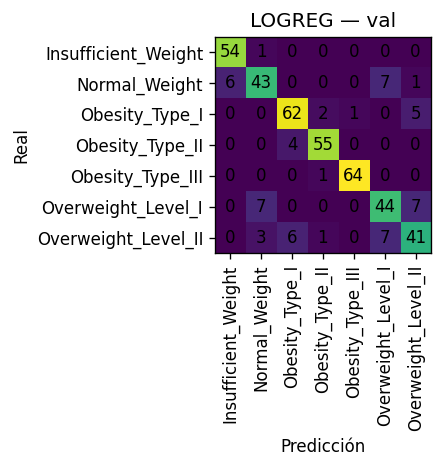

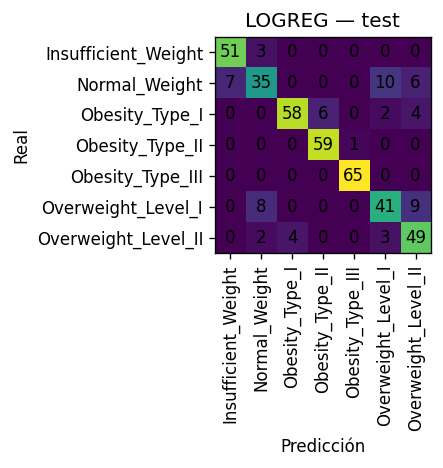

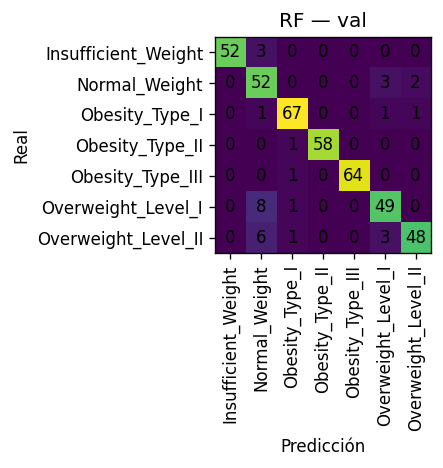

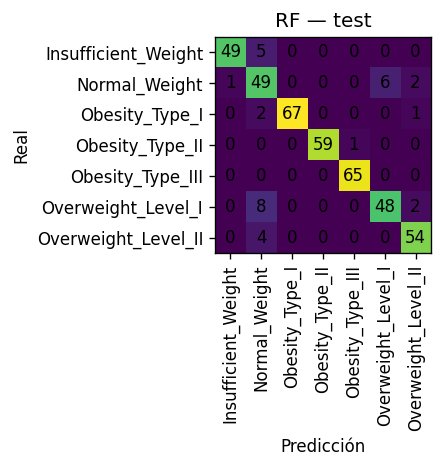

In [20]:
# Leemos el JSON de métricas para visualizar matrices
with open(OUT_DIR / "reports" / "metrics.json", "r", encoding="utf-8") as f:
    metrics = json.load(f)

def plot_confusion(cm_dict, title):
    """Dibuja una matriz de confusión con etiquetas y conteos."""
    labels = cm_dict["labels"]
    mat = np.array(cm_dict["matrix"])
    plt.figure(figsize=(4.5, 4))
    plt.imshow(mat, interpolation="nearest")
    plt.title(title)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.yticks(range(len(labels)), labels)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, mat[i, j], ha="center", va="center")
    plt.xlabel("Predicción"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

# Graficamos para cada modelo y split
for model in ["logreg", "rf"]:
    for split in ["val", "test"]:
        cm = metrics[model][split]["confusion_matrix"]
        plot_confusion(cm, f"{model.upper()} — {split}")
